In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, make_scorer, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
import seaborn as sns
import gpboost as gpb
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('mergedfile_patient_age_yearsall.txt', sep='\t')

In [4]:
mutation_cols = df.columns[1:12941]     
meta_cols_before = df.columns[:1]      
meta_cols_after = df.columns[12941:]   
new_cols = pd.DataFrame(index=df.index)
for col in mutation_cols:
    parts = col.split(',')
    base = parts[0]      
    alleles = parts[1:] 
    col_numeric = pd.to_numeric(df[col], errors='coerce')
    new_cols[base] = col_numeric.apply(lambda x: 1 if x > 0 else 0)

    for i, allele in enumerate(alleles, start=1):
        allele_col = base[:-1] + allele  
        new_cols[allele_col] = col_numeric.apply(lambda x: 1 if x == i else 0)
final_df = pd.concat([df[meta_cols_before], new_cols, df[meta_cols_after]], axis=1)

In [5]:
cols_with_star = [col for col in final_df.columns if '*' in col]
print(cols_with_star[:10])

['A1*', 'T2*', 'T3*', 'A4*', 'A5*', 'A6*', 'G7*', 'G8*', 'T9*', 'T10*']


In [6]:
final_df = final_df.drop(columns=cols_with_star)

In [7]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29875G,A29876G,A29877T,A29891G,A29892G,Location,Gender,Patient age,Additional host information,Lineage
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Europe / Turkey,Male,87.00,Severe,B
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Slovakia / Okres Presov,Female,91.00,Severe,B.1.1.529
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,South America / Brazil / Rio de Janeiro / Rio ...,Male,35.00,Severe,BA.1
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Male,70.00,Severe,EG.5.1.1
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Female,19.00,Severe,HK.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Male,94.00,Severe,JN.1.4 (consensus call)
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Female,81.00,Severe,KP.3.1.1 (consensus call)
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / USA / New York / Westchester C...,Male,0.42,Severe,JN.1.4 (consensus call)
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / Mexico / Guanajuato,Female,26.00,Severe,XBB.1.16.15


In [8]:
final_df.drop(columns=['Location', 'Lineage', 'Additional host information'], inplace=True)

In [9]:
metadatatwo = pd.read_csv("metadata2.txt", sep="\t")  
finalfile = pd.merge(final_df, metadatatwo, on="strain")

In [10]:
finalfile

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [11]:
finalfile['Gender'] = finalfile['Gender'].replace('Hombre', 'Male')  
finalfile['Gender'] = finalfile['Gender'].replace('Mujer', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Malex', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Famale', 'Female')

In [12]:
finalfile['Gender'].value_counts()

Gender
Female    7856
Male      6121
Name: count, dtype: int64

In [13]:
final_df=finalfile

In [14]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [15]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64


In [16]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int64


In [17]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [19]:
first_col = final_df.loc[:, ["strain","country", "region"]]

In [21]:
rest = final_df.drop(columns=["strain", "country", "region"])
rest

,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,A4T,...,Nextclade_pango_XEL.3,Nextclade_pango_XEP,Nextclade_pango_XEU,Nextclade_pango_XEV,Nextclade_pango_XEW,Nextclade_pango_XFB,Nextclade_pango_XFC,Nextclade_pango_XFG,Nextclade_pango_XFJ,Nextclade_pango_XFL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13973,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13974,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13975,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13977, 9609)


In [23]:
final_df_filtered

,strain,country,region,T2G,T3C,A4T,A4C,A5G,A6R,G7T,...,Nextclade_pango_XEC.15,Nextclade_pango_XEC.18,Nextclade_pango_XEC.2,Nextclade_pango_XEC.30,Nextclade_pango_XEC.32,Nextclade_pango_XEC.4,Nextclade_pango_XEC.8,Nextclade_pango_XEC.9,Nextclade_pango_XEE,Nextclade_pango_XEK
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,Turkey,Europe,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,Slovakia,Europe,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,Brazil,South America,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,China,Asia,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,China,Asia,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,Spain,Europe,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,Spain,Europe,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13974,hCoV-19/USA/NY-WMC-6178/2024,USA,North America,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,Mexico,North America,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
final_df_filtered['country_encoded'] = le_country.fit_transform(final_df_filtered['country'])

le_region = LabelEncoder()
final_df_filtered['region_encoded'] = le_region.fit_transform(final_df_filtered['region'])
group_data = final_df_filtered[['country_encoded', 'region_encoded']].values
fixed_effects = final_df_filtered.drop(columns=['strain','category', 'country_encoded', 'region_encoded', 'country', 'region'])  
random_effects = final_df_filtered[['country', 'region']]  # Random effect groups
target = final_df_filtered['category']
X,y, group = fixed_effects, target, group_data

In [25]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

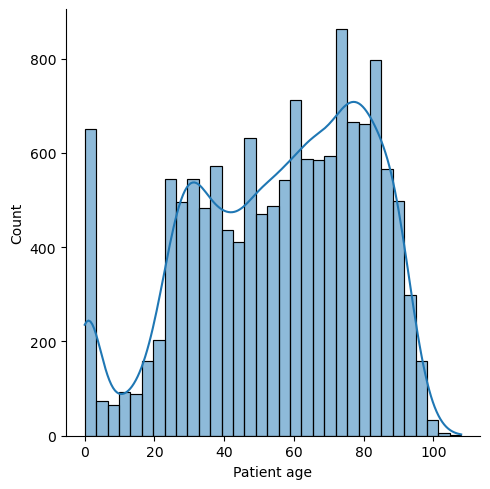

In [26]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [27]:
group_data = final_df_filtered[['country_encoded', 'region_encoded']]

In [28]:
groups = final_df_filtered['country']

In [31]:
def fit_gpboost_binary(X_mat, y_vec, group_mat, params):
    """Train a GPBoost binary classifier with Bernoulli likelihood (random effects from group_mat)."""
    gp_model = gpb.GPModel(
        group_data=group_mat,               # shape (n, 2): [country, country#region]
        likelihood="bernoulli_probit"
    )
    p_ = dict(params)
    p_["objective"] = "binary"
    train_set = gpb.Dataset(data=X_mat, label=y_vec.astype(np.float32))
    model = gpb.train(
        params=p_,
        train_set=train_set,
        gp_model=gp_model,
        num_boost_round=p_["n_estimators"]
    )
    return model

In [33]:
def extract_prob(preds):
    """Handle GPBoost predict() output (dict or ndarray)."""
    if isinstance(preds, dict) and "response_mean" in preds:
        return preds["response_mean"]
    return preds

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13920, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.084650
[GPBoost] [Info] Start training from score 2.084650

=== Fold 1: Test country = Argentina ===
Train size: 13920, Test size: 57
Params: {'n_estimators': 642, 'max_depth': 33, 'learning_rate': 0.04401008709570113, 'num_leaves': 27, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0117
ECE (10 bins):     0.0974
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



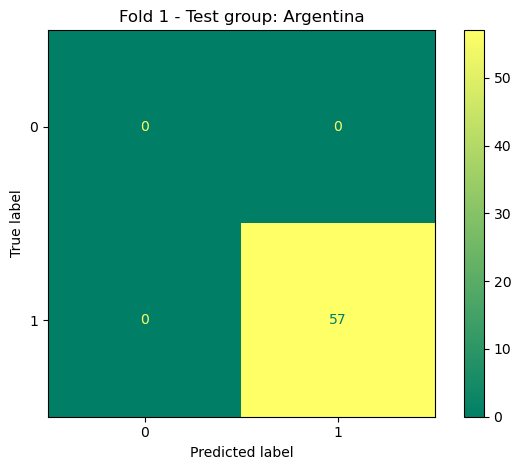

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.126756
[GPBoost] [Info] Start training from score 2.126756

=== Fold 2: Test country = Austria ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 1309, 'max_depth': 30, 'learning_rate': 0.005289981716621668, 'num_leaves': 33, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0435
ECE (10 bins):     0.2087
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



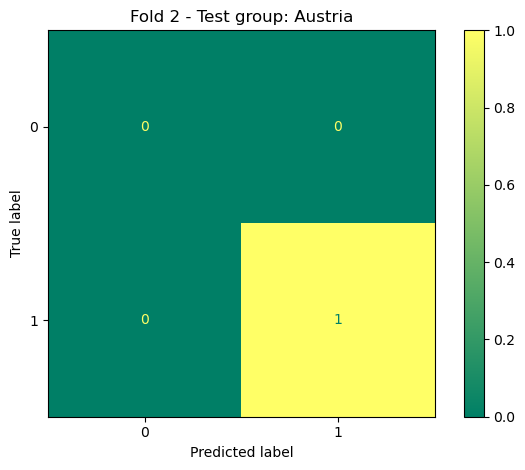

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13972, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118198
[GPBoost] [Info] Start training from score 2.118198

=== Fold 3: Test country = Belgium ===
Train size: 13972, Test size: 5
Params: {'n_estimators': 1567, 'max_depth': 13, 'learning_rate': 0.026295081327731756, 'num_leaves': 37, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0098
ECE (10 bins):     0.0991
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



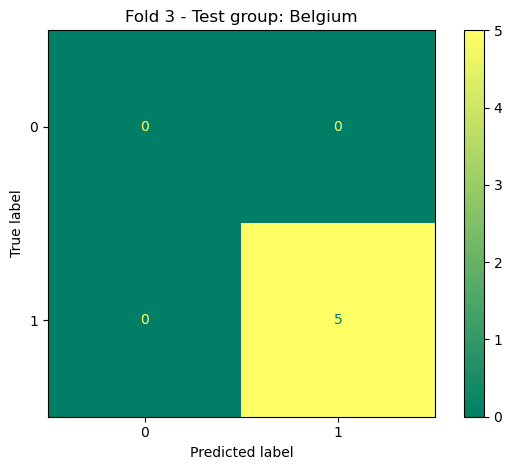

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13975, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.130359
[GPBoost] [Info] Start training from score 2.130359

=== Fold 4: Test country = Botswana ===
Train size: 13975, Test size: 2
Params: {'n_estimators': 1980, 'max_depth': 27, 'learning_rate': 0.052792132226679875, 'num_leaves': 31, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0164
ECE (10 bins):     0.1161
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



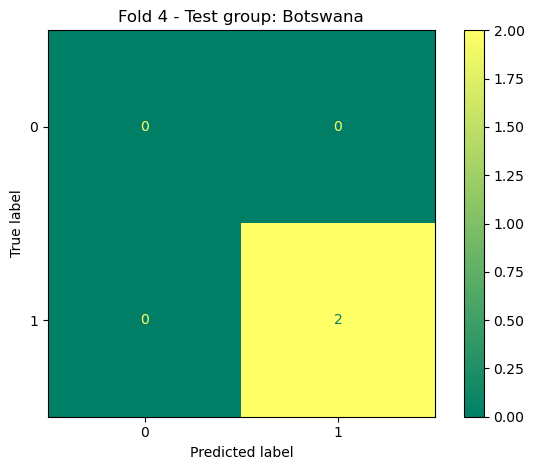

[GPBoost] [Info] Total Bins 19303
[GPBoost] [Info] Number of data points in the train set: 13059, number of used features: 9590
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.031803
[GPBoost] [Info] Start training from score 2.031803

=== Fold 5: Test country = Brazil ===
Train size: 13059, Test size: 918
Params: {'n_estimators': 1304, 'max_depth': 38, 'learning_rate': 0.008568225734750834, 'num_leaves': 32, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0230
ECE (10 bins):     0.1397
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       918

    accuracy                           1.00       918
   macro avg       1.00      1.00      1.00       918
weighted avg       1.00      1.00      1.00       918



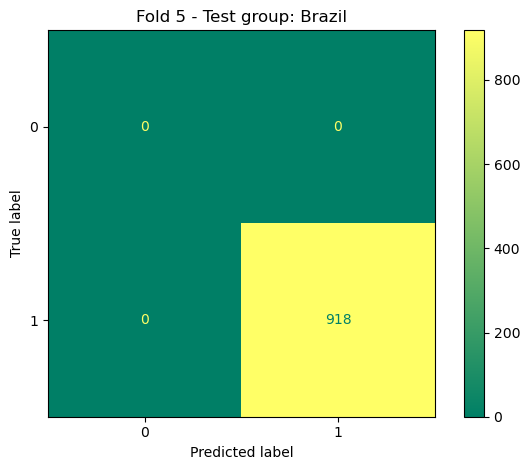

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.134729
[GPBoost] [Info] Start training from score 2.134729

=== Fold 6: Test country = Bulgaria ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 655, 'max_depth': 32, 'learning_rate': 0.07485954407772158, 'num_leaves': 27, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0043
ECE (10 bins):     0.0652
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



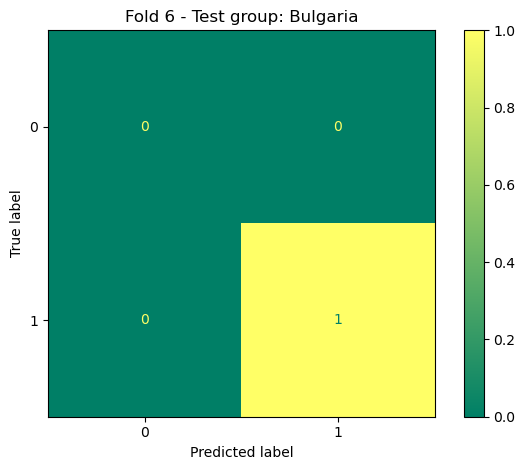

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13568, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.072498
[GPBoost] [Info] Start training from score 2.072498

=== Fold 7: Test country = China ===
Train size: 13568, Test size: 409
Params: {'n_estimators': 708, 'max_depth': 22, 'learning_rate': 0.05938580202287532, 'num_leaves': 37, 'seed': 42}
Accuracy: 0.9902
Precision (macro): 0.5000
Recall (macro):    0.4951
F1-score (macro):  0.4975
Brier score:       0.0417
ECE (10 bins):     0.1808
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      1.00       409

    accuracy                           0.99       409
   macro avg       0.50      0.50      0.50       409
weighted avg       1.00      0.99      1.00       409



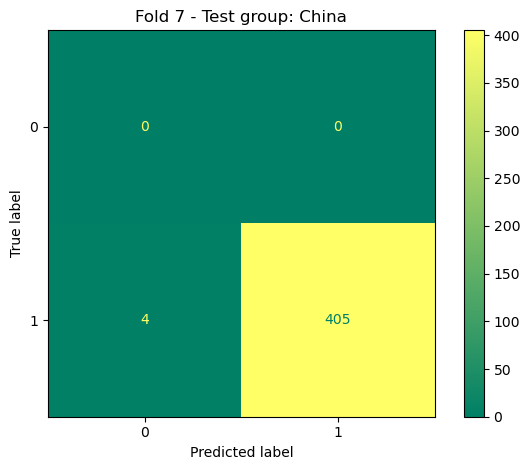

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13961, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.114542
[GPBoost] [Info] Start training from score 2.114542

=== Fold 8: Test country = Colombia ===
Train size: 13961, Test size: 16
Params: {'n_estimators': 568, 'max_depth': 21, 'learning_rate': 0.05913529149663377, 'num_leaves': 11, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0235
ECE (10 bins):     0.1519
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



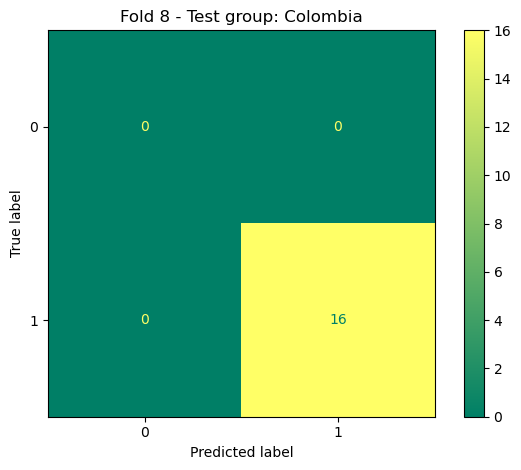

[GPBoost] [Info] Total Bins 19308
[GPBoost] [Info] Number of data points in the train set: 9158, number of used features: 9594
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.241398
[GPBoost] [Info] Start training from score 2.241398

=== Fold 9: Test country = France ===
Train size: 9158, Test size: 4819
Params: {'n_estimators': 1750, 'max_depth': 34, 'learning_rate': 0.08269959478919109, 'num_leaves': 43, 'seed': 42}
Accuracy: 0.2994
Precision (macro): 0.5382
Recall (macro):    0.5003
F1-score (macro):  0.2319
Brier score:       0.4859
ECE (10 bins):     0.5254
ROC AUC:           0.5438
AUPRC:             0.3294

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.00      0.00      3381
           1       0.30      1.00      0.46      1438

    accuracy                           0.30      4819
   macro avg       0.54      0.50      0.23      4819
weighted avg       0.63      0.30      0.14      4819



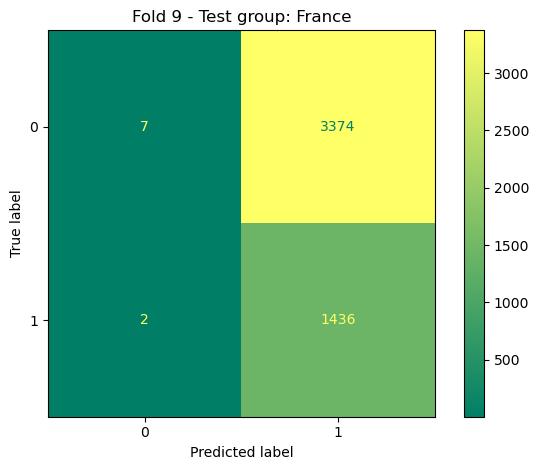

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13951, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.109952
[GPBoost] [Info] Start training from score 2.109952

=== Fold 10: Test country = Germany ===
Train size: 13951, Test size: 26
Params: {'n_estimators': 1115, 'max_depth': 39, 'learning_rate': 0.031099559357296535, 'num_leaves': 24, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0110
ECE (10 bins):     0.1030
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        26

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



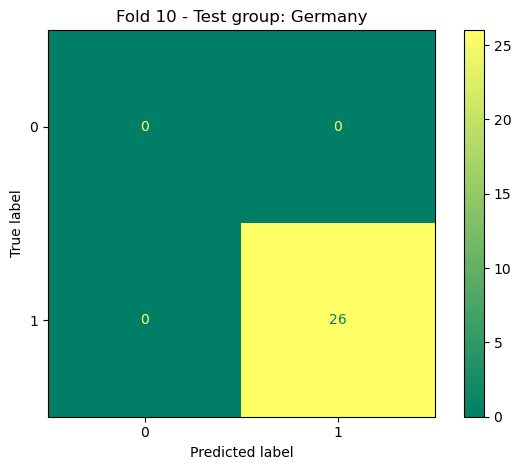

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13930, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.226160
[GPBoost] [Info] Start training from score 2.226160

=== Fold 11: Test country = Guadeloupe ===
Train size: 13930, Test size: 47
Params: {'n_estimators': 2044, 'max_depth': 29, 'learning_rate': 0.05727417697225861, 'num_leaves': 29, 'seed': 42}
Accuracy: 0.2766
Precision (macro): 0.1383
Recall (macro):    0.5000
F1-score (macro):  0.2167
Brier score:       0.4485
ECE (10 bins):     0.5166
ROC AUC:           0.8145
AUPRC:             0.5436

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.28      1.00      0.43        13

    accuracy                           0.28        47
   macro avg       0.14      0.50      0.22        47
weighted avg       0.08      0.28      0.12        

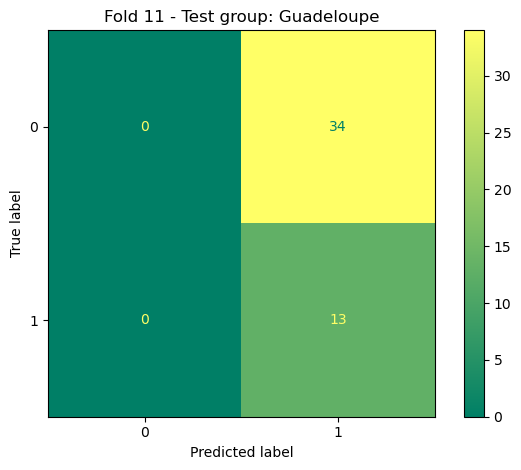

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13975, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.111206
[GPBoost] [Info] Start training from score 2.111206

=== Fold 12: Test country = Guatemala ===
Train size: 13975, Test size: 2
Params: {'n_estimators': 1710, 'max_depth': 10, 'learning_rate': 0.07145324406923469, 'num_leaves': 43, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0175
ECE (10 bins):     0.1274
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



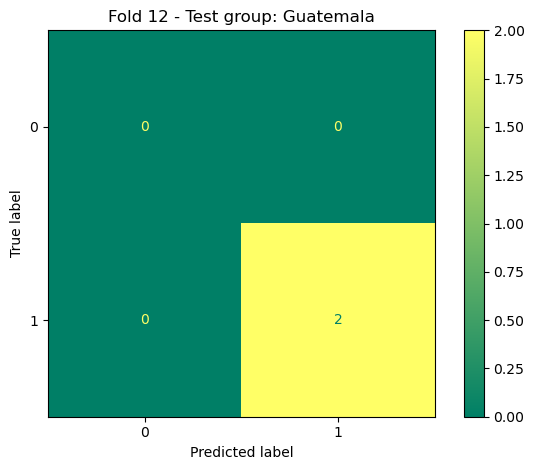

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.133630
[GPBoost] [Info] Start training from score 2.133630

=== Fold 13: Test country = Guinea ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 997, 'max_depth': 16, 'learning_rate': 0.051820837146529464, 'num_leaves': 30, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0135
ECE (10 bins):     0.1160
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



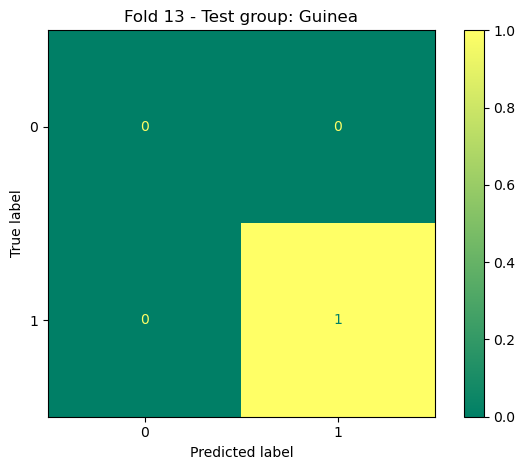

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13974, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.132141
[GPBoost] [Info] Start training from score 2.132141

=== Fold 14: Test country = India ===
Train size: 13974, Test size: 3
Params: {'n_estimators': 2042, 'max_depth': 35, 'learning_rate': 0.08632326994820144, 'num_leaves': 19, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0051
ECE (10 bins):     0.0703
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



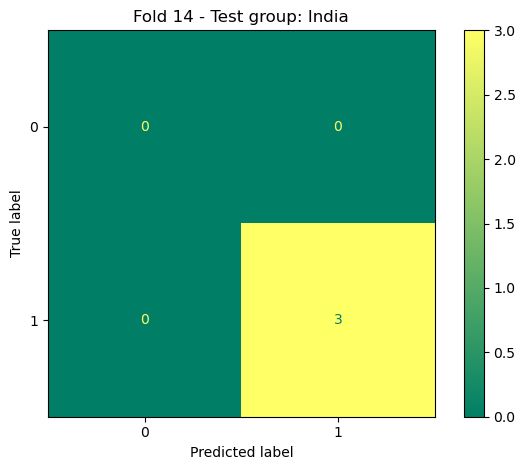

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13944, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.320459
[GPBoost] [Info] Start training from score 2.320459

=== Fold 15: Test country = Indonesia ===
Train size: 13944, Test size: 33
Params: {'n_estimators': 1087, 'max_depth': 32, 'learning_rate': 0.002656475818907031, 'num_leaves': 48, 'seed': 42}
Accuracy: 0.1212
Precision (macro): 0.0606
Recall (macro):    0.5000
F1-score (macro):  0.1081
Brier score:       0.7039
ECE (10 bins):     0.7779
ROC AUC:           1.0000
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.12      1.00      0.22         4

    accuracy                           0.12        33
   macro avg       0.06      0.50      0.11        33
weighted avg       0.01      0.12      0.03        

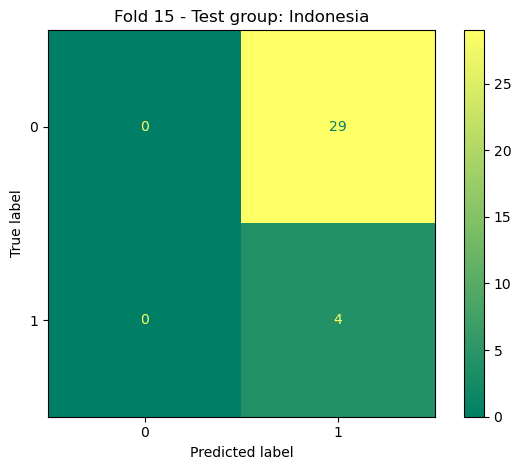

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13974, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.132494
[GPBoost] [Info] Start training from score 2.132494

=== Fold 16: Test country = Iran ===
Train size: 13974, Test size: 3
Params: {'n_estimators': 604, 'max_depth': 31, 'learning_rate': 0.046894572885321714, 'num_leaves': 46, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0095
ECE (10 bins):     0.0917
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



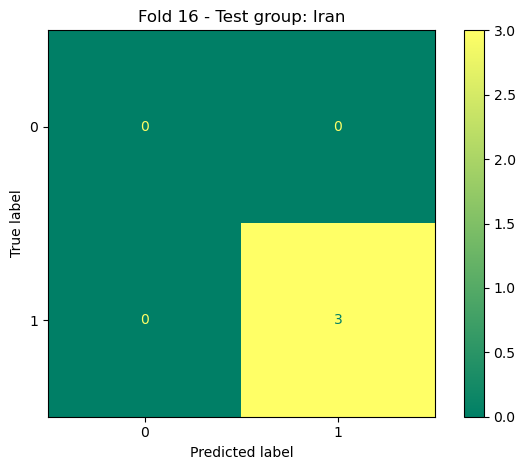

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.134767
[GPBoost] [Info] Start training from score 2.134767

=== Fold 17: Test country = Ireland ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 1316, 'max_depth': 19, 'learning_rate': 0.08722369370461555, 'num_leaves': 49, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0108
ECE (10 bins):     0.1040
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



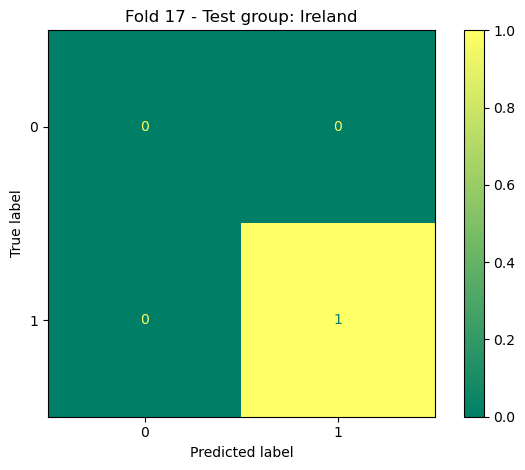

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13931, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.160175
[GPBoost] [Info] Start training from score 2.160175

=== Fold 18: Test country = Italy ===
Train size: 13931, Test size: 46
Params: {'n_estimators': 1763, 'max_depth': 28, 'learning_rate': 0.08195448448348586, 'num_leaves': 35, 'seed': 42}
Accuracy: 0.8913
Precision (macro): 0.4457
Recall (macro):    0.5000
F1-score (macro):  0.4713
Brier score:       0.1037
ECE (10 bins):     0.0482
ROC AUC:           0.5902
AUPRC:             0.9417

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.89      1.00      0.94        41

    accuracy                           0.89        46
   macro avg       0.45      0.50      0.47        46
weighted avg       0.79      0.89      0.84        46



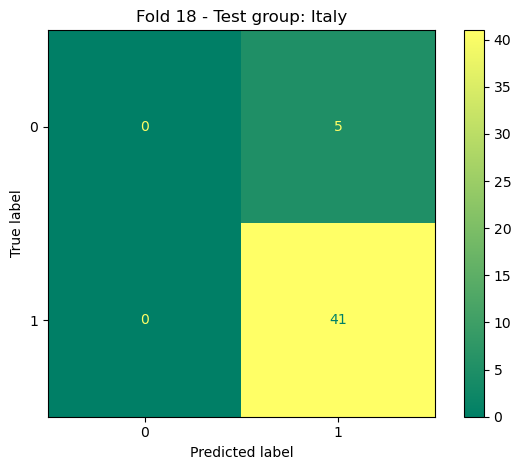

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13973, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.120044
[GPBoost] [Info] Start training from score 2.120044

=== Fold 19: Test country = Kenya ===
Train size: 13973, Test size: 4
Params: {'n_estimators': 778, 'max_depth': 20, 'learning_rate': 0.003660346405710447, 'num_leaves': 49, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0170
ECE (10 bins):     0.1282
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



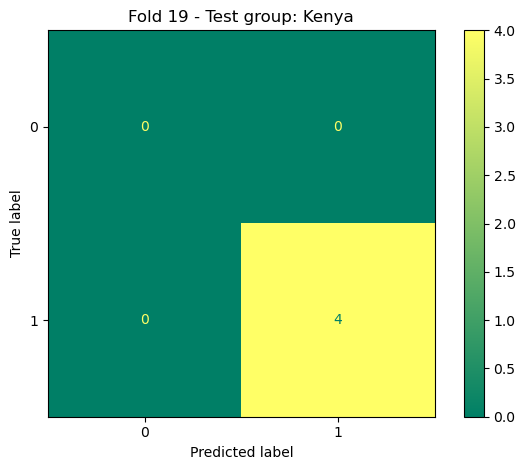

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13953, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.119265
[GPBoost] [Info] Start training from score 2.119265

=== Fold 20: Test country = Kosovo ===
Train size: 13953, Test size: 24
Params: {'n_estimators': 1177, 'max_depth': 21, 'learning_rate': 0.07664969058284213, 'num_leaves': 29, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0636
ECE (10 bins):     0.2381
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        24

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



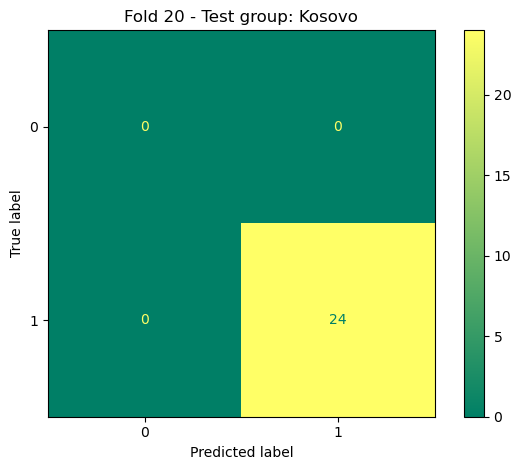

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13965, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.115819
[GPBoost] [Info] Start training from score 2.115819

=== Fold 21: Test country = Lebanon ===
Train size: 13965, Test size: 12
Params: {'n_estimators': 1216, 'max_depth': 28, 'learning_rate': 0.07428178379348756, 'num_leaves': 42, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0125
ECE (10 bins):     0.1012
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



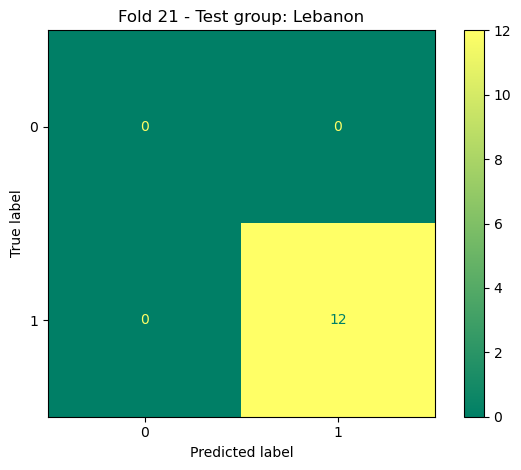

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13965, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118794
[GPBoost] [Info] Start training from score 2.118794

=== Fold 22: Test country = Malaysia ===
Train size: 13965, Test size: 12
Params: {'n_estimators': 1229, 'max_depth': 27, 'learning_rate': 0.09824136914824314, 'num_leaves': 48, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0344
ECE (10 bins):     0.1693
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



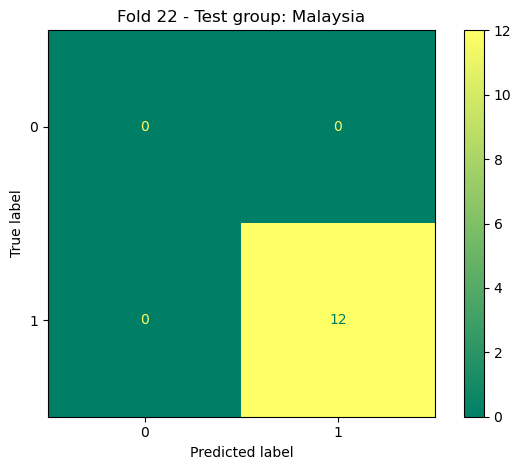

[GPBoost] [Info] Total Bins 19217
[GPBoost] [Info] Number of data points in the train set: 10998, number of used features: 9547
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.152036
[GPBoost] [Info] Start training from score 2.152036

=== Fold 23: Test country = Mexico ===
Train size: 10998, Test size: 2979
Params: {'n_estimators': 1316, 'max_depth': 39, 'learning_rate': 0.05228728365579279, 'num_leaves': 20, 'seed': 42}
Accuracy: 0.6737
Precision (macro): 0.6400
Recall (macro):    0.6341
F1-score (macro):  0.6363
Brier score:       0.2132
ECE (10 bins):     0.0985
ROC AUC:           0.6804
AUPRC:             0.7848

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.50      0.52      1057
           1       0.74      0.77      0.75      1922

    accuracy                           0.67      2979
   macro avg       0.64      0.63      0.64      2979
weighted avg       0.67      0.67      0.67      2979

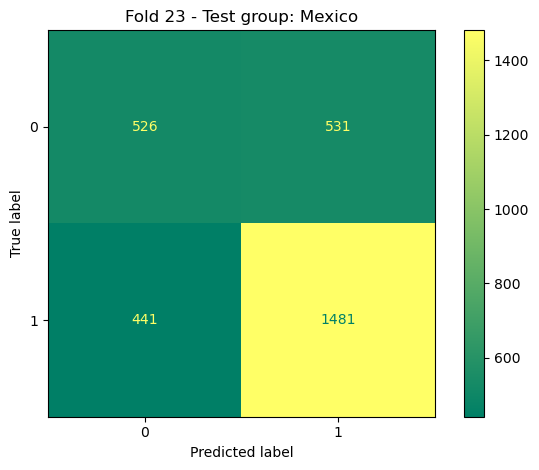

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13920, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.099526
[GPBoost] [Info] Start training from score 2.099526

=== Fold 24: Test country = Moldova ===
Train size: 13920, Test size: 57
Params: {'n_estimators': 779, 'max_depth': 11, 'learning_rate': 0.051785773398879506, 'num_leaves': 22, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0226
ECE (10 bins):     0.1494
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



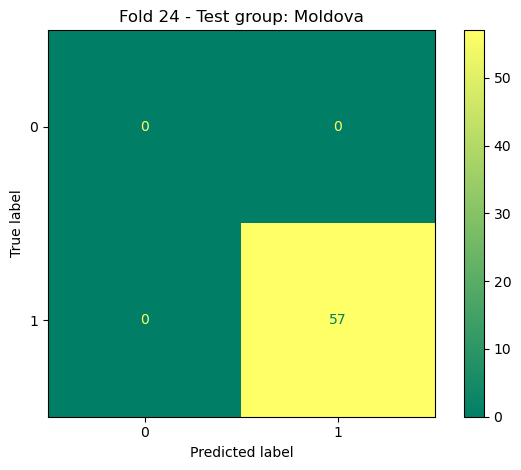

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13958, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.115757
[GPBoost] [Info] Start training from score 2.115757

=== Fold 25: Test country = Montenegro ===
Train size: 13958, Test size: 19
Params: {'n_estimators': 2008, 'max_depth': 38, 'learning_rate': 0.06889617685018402, 'num_leaves': 36, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0125
ECE (10 bins):     0.1056
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        19

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



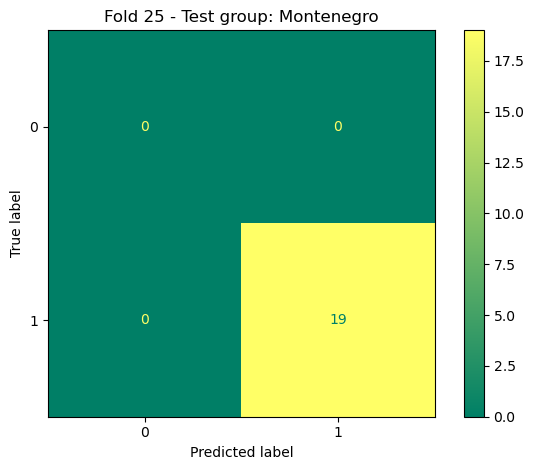

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13895, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.103141
[GPBoost] [Info] Start training from score 2.103141

=== Fold 26: Test country = Pakistan ===
Train size: 13895, Test size: 82
Params: {'n_estimators': 1753, 'max_depth': 22, 'learning_rate': 0.013439953615607424, 'num_leaves': 28, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0332
ECE (10 bins):     0.1750
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        82

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



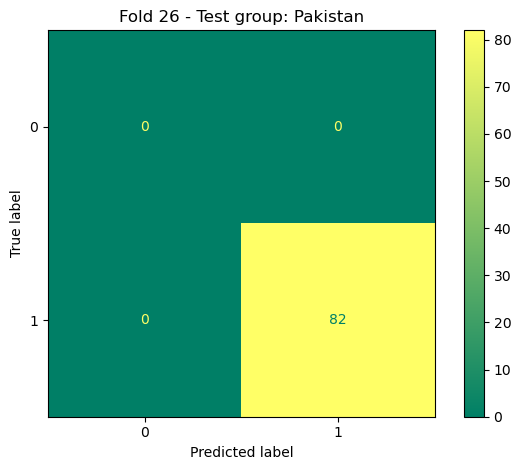

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13955, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.100506
[GPBoost] [Info] Start training from score 2.100506

=== Fold 27: Test country = Paraguay ===
Train size: 13955, Test size: 22
Params: {'n_estimators': 1279, 'max_depth': 25, 'learning_rate': 0.08413597490620241, 'num_leaves': 22, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0051
ECE (10 bins):     0.0700
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



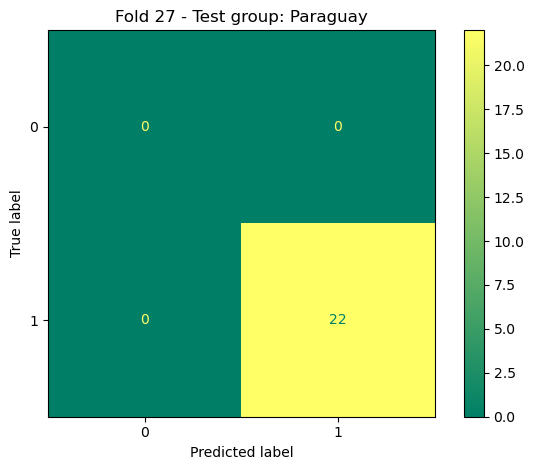

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13973, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.224777
[GPBoost] [Info] Start training from score 2.224777

=== Fold 28: Test country = Philippines ===
Train size: 13973, Test size: 4
Params: {'n_estimators': 585, 'max_depth': 27, 'learning_rate': 0.05263149951030567, 'num_leaves': 42, 'seed': 42}
Accuracy: 0.2500
Precision (macro): 0.1250
Recall (macro):    0.5000
F1-score (macro):  0.2000
Brier score:       0.5595
ECE (10 bins):     0.6258
ROC AUC:           1.0000
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      1.00      0.40         1

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         

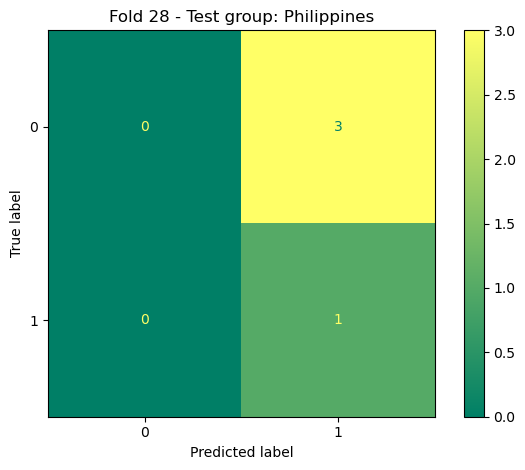

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13959, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.115377
[GPBoost] [Info] Start training from score 2.115377

=== Fold 29: Test country = Poland ===
Train size: 13959, Test size: 18
Params: {'n_estimators': 1535, 'max_depth': 21, 'learning_rate': 0.07193297338937645, 'num_leaves': 24, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0136
ECE (10 bins):     0.1042
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



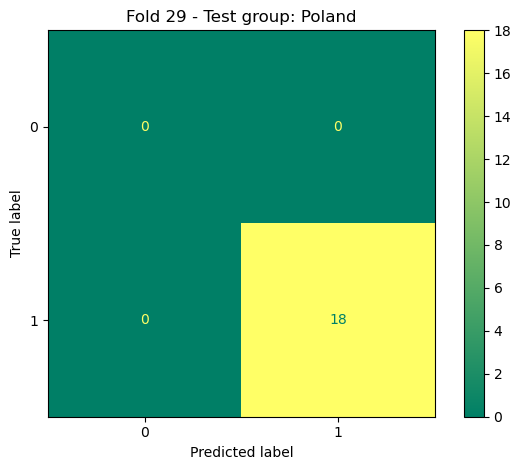

[GPBoost] [Info] Total Bins 19331
[GPBoost] [Info] Number of data points in the train set: 13792, number of used features: 9604
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.089923
[GPBoost] [Info] Start training from score 2.089923

=== Fold 30: Test country = Qatar ===
Train size: 13792, Test size: 185
Params: {'n_estimators': 2024, 'max_depth': 17, 'learning_rate': 0.05269880589334973, 'num_leaves': 31, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0047
ECE (10 bins):     0.0680
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       185

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



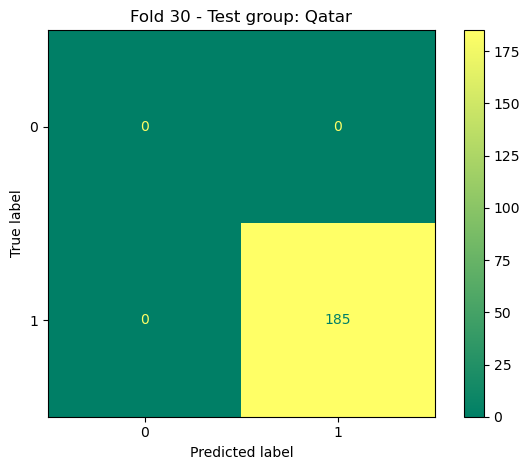

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13968, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118219
[GPBoost] [Info] Start training from score 2.118219

=== Fold 31: Test country = Romania ===
Train size: 13968, Test size: 9
Params: {'n_estimators': 2024, 'max_depth': 35, 'learning_rate': 0.001654162022484112, 'num_leaves': 25, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0300
ECE (10 bins):     0.1695
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



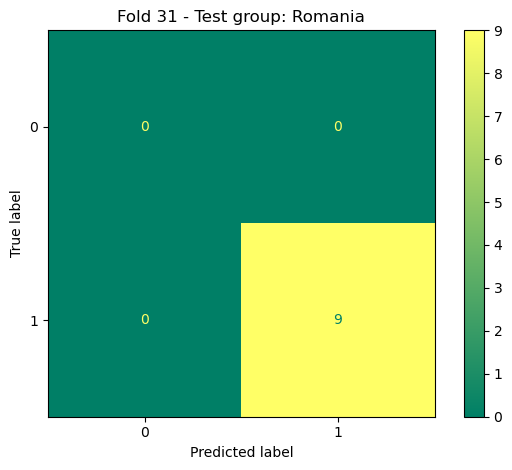

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.135101
[GPBoost] [Info] Start training from score 2.135101

=== Fold 32: Test country = Russia ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 1810, 'max_depth': 25, 'learning_rate': 0.030730018710420165, 'num_leaves': 11, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.1011
ECE (10 bins):     0.3180
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



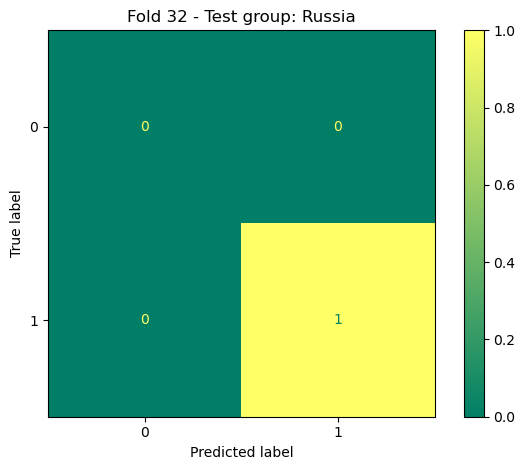

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13976, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.165473
[GPBoost] [Info] Start training from score 2.165473

=== Fold 33: Test country = Saint Martin ===
Train size: 13976, Test size: 1
Params: {'n_estimators': 817, 'max_depth': 37, 'learning_rate': 0.05203065311782814, 'num_leaves': 45, 'seed': 42}
Accuracy: 0.0000
Precision (macro): 0.0000
Recall (macro):    0.0000
F1-score (macro):  0.0000
Brier score:       0.7301
ECE (10 bins):     0.8545
AUPRC:             0.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



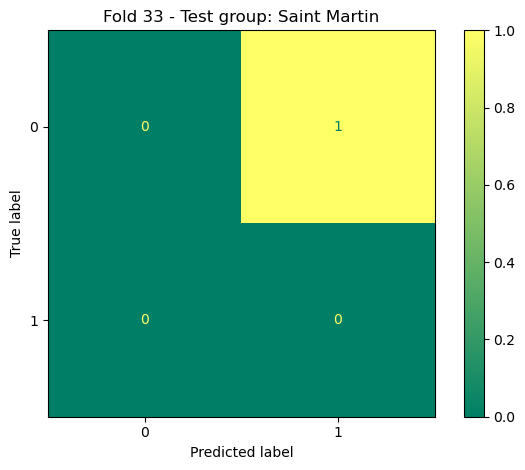

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13943, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.073972
[GPBoost] [Info] Start training from score 2.073972

=== Fold 34: Test country = Senegal ===
Train size: 13943, Test size: 34
Params: {'n_estimators': 1562, 'max_depth': 16, 'learning_rate': 0.01600664658933536, 'num_leaves': 48, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0326
ECE (10 bins):     0.1740
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        34

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



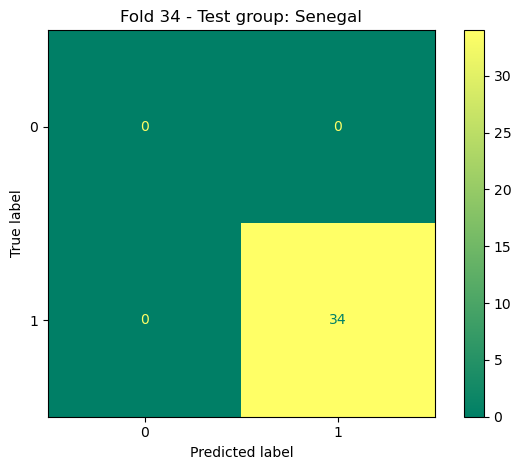

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13908, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.099586
[GPBoost] [Info] Start training from score 2.099586

=== Fold 35: Test country = Slovakia ===
Train size: 13908, Test size: 69
Params: {'n_estimators': 1405, 'max_depth': 34, 'learning_rate': 0.09758128400524069, 'num_leaves': 26, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0296
ECE (10 bins):     0.1604
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        69

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



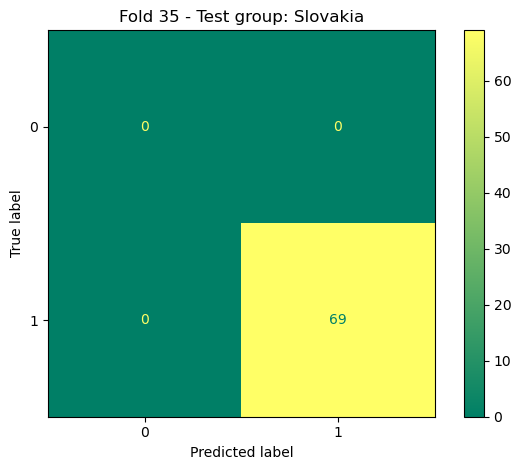

[GPBoost] [Info] Total Bins 19228
[GPBoost] [Info] Number of data points in the train set: 10366, number of used features: 9554
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.183732
[GPBoost] [Info] Start training from score 2.183732

=== Fold 36: Test country = Spain ===
Train size: 10366, Test size: 3611
Params: {'n_estimators': 595, 'max_depth': 34, 'learning_rate': 0.05501485166843089, 'num_leaves': 42, 'seed': 42}
Accuracy: 0.7563
Precision (macro): 0.3782
Recall (macro):    0.5000
F1-score (macro):  0.4306
Brier score:       0.1861
ECE (10 bins):     0.0849
ROC AUC:           0.5775
AUPRC:             0.7796

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       880
           1       0.76      1.00      0.86      2731

    accuracy                           0.76      3611
   macro avg       0.38      0.50      0.43      3611
weighted avg       0.57      0.76      0.65      3611



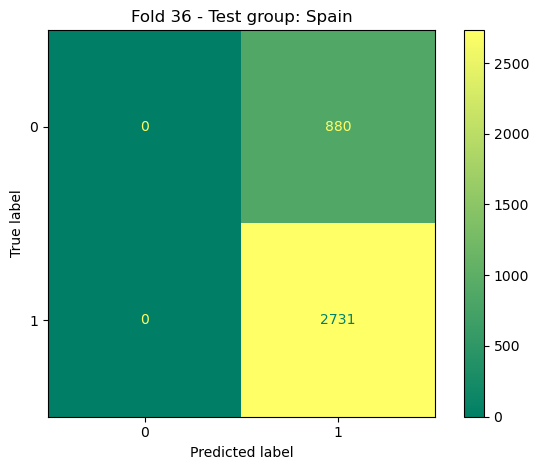

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13831, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.094111
[GPBoost] [Info] Start training from score 2.094111

=== Fold 37: Test country = Taiwan ===
Train size: 13831, Test size: 146
Params: {'n_estimators': 1673, 'max_depth': 22, 'learning_rate': 0.09068325977137123, 'num_leaves': 13, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0429
ECE (10 bins):     0.1835
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       146

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



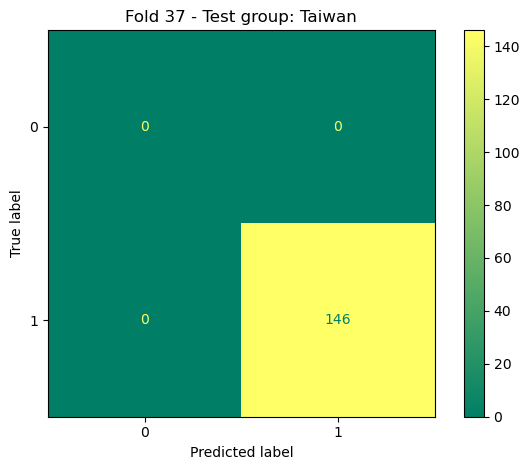

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13940, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.106493
[GPBoost] [Info] Start training from score 2.106493

=== Fold 38: Test country = Thailand ===
Train size: 13940, Test size: 37
Params: {'n_estimators': 671, 'max_depth': 38, 'learning_rate': 0.008019015467038416, 'num_leaves': 50, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0145
ECE (10 bins):     0.1184
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        37

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



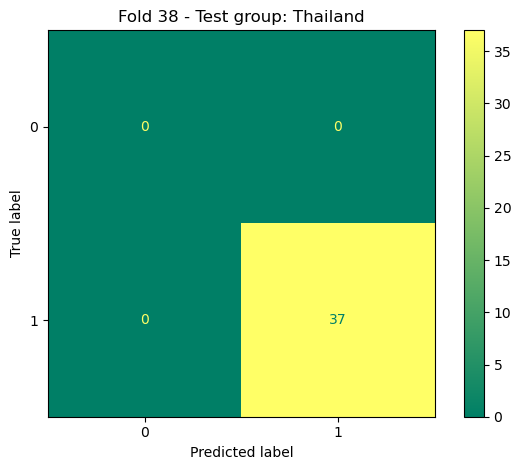

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13970, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.119168
[GPBoost] [Info] Start training from score 2.119168

=== Fold 39: Test country = Turkey ===
Train size: 13970, Test size: 7
Params: {'n_estimators': 1953, 'max_depth': 32, 'learning_rate': 0.002805042088987626, 'num_leaves': 38, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0206
ECE (10 bins):     0.1410
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



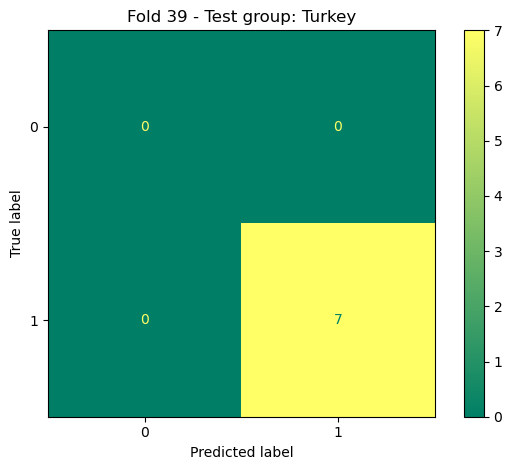

[GPBoost] [Info] Total Bins 19332
[GPBoost] [Info] Number of data points in the train set: 13745, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.107315
[GPBoost] [Info] Start training from score 2.107315

=== Fold 40: Test country = USA ===
Train size: 13745, Test size: 232
Params: {'n_estimators': 592, 'max_depth': 23, 'learning_rate': 0.021739575650523903, 'num_leaves': 36, 'seed': 42}
Accuracy: 0.8276
Precision (macro): 0.4138
Recall (macro):    0.5000
F1-score (macro):  0.4528
Brier score:       0.1427
ECE (10 bins):     0.0360
ROC AUC:           0.5904
AUPRC:             0.8719

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.83      1.00      0.91       192

    accuracy                           0.83       232
   macro avg       0.41      0.50      0.45       232
weighted avg       0.68      0.83      0.75       232



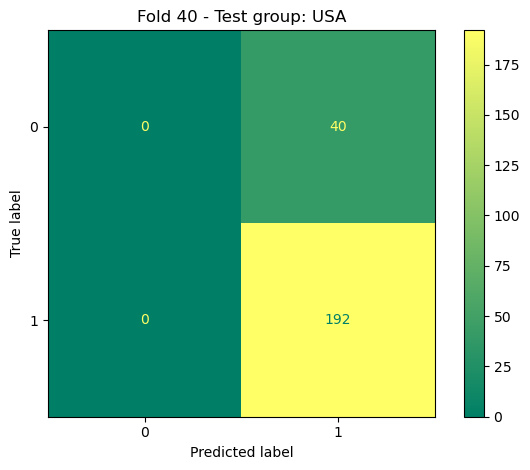

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13971, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118468
[GPBoost] [Info] Start training from score 2.118468

=== Fold 41: Test country = Uganda ===
Train size: 13971, Test size: 6
Params: {'n_estimators': 1647, 'max_depth': 40, 'learning_rate': 0.08476921899479675, 'num_leaves': 48, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0285
ECE (10 bins):     0.1450
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



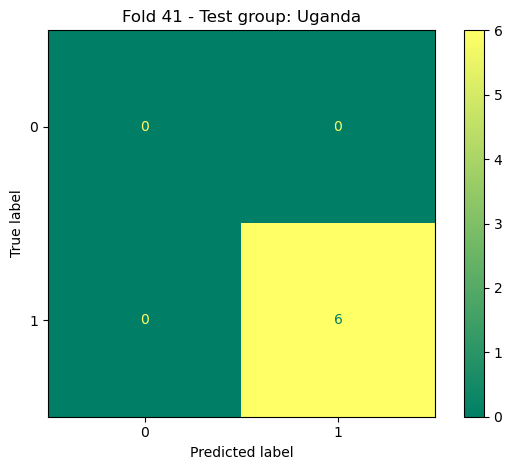

[GPBoost] [Info] Total Bins 19333
[GPBoost] [Info] Number of data points in the train set: 13961, number of used features: 9605
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118604
[GPBoost] [Info] Start training from score 2.118604

=== Fold 42: Test country = Vietnam ===
Train size: 13961, Test size: 16
Params: {'n_estimators': 1694, 'max_depth': 19, 'learning_rate': 0.0053712762482720266, 'num_leaves': 22, 'seed': 42}
Accuracy: 1.0000
Precision (macro): 0.5000
Recall (macro):    0.5000
F1-score (macro):  0.5000
Brier score:       0.0243
ECE (10 bins):     0.1550
AUPRC:             1.0000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



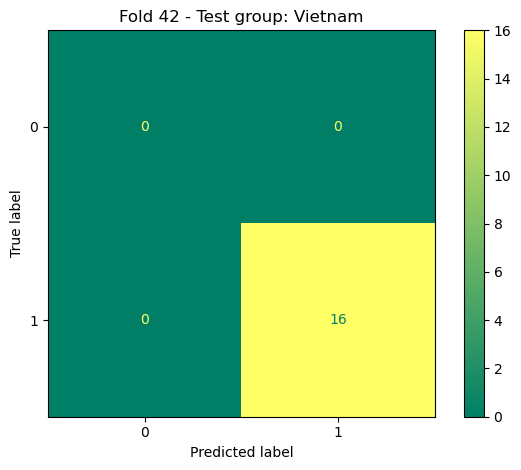


=== All Results ===
    Fold       Country  Accuracy   ROC_AUC  Precision    Recall        F1  \
0      1     Argentina  1.000000       NaN   0.500000  0.500000  0.500000   
1      2       Austria  1.000000       NaN   0.500000  0.500000  0.500000   
2      3       Belgium  1.000000       NaN   0.500000  0.500000  0.500000   
3      4      Botswana  1.000000       NaN   0.500000  0.500000  0.500000   
4      5        Brazil  1.000000       NaN   0.500000  0.500000  0.500000   
5      6      Bulgaria  1.000000       NaN   0.500000  0.500000  0.500000   
6      7         China  0.990220       NaN   0.500000  0.495110  0.497543   
7      8      Colombia  1.000000       NaN   0.500000  0.500000  0.500000   
8      9        France  0.299440  0.543836   0.538161  0.500340  0.231898   
9     10       Germany  1.000000       NaN   0.500000  0.500000  0.500000   
10    11    Guadeloupe  0.276596  0.814480   0.138298  0.500000  0.216667   
11    12     Guatemala  1.000000       NaN   0.500000  

KeyError: 'ECE'

In [34]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, precision_recall_fscore_support, ConfusionMatrixDisplay,
    brier_score_loss, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def prf_macro_over_fixed_labels(y_true, y_pred, labels):
    """
    Macro Precision/Recall/F1 computed over a fixed label list.
    If a class is absent in y_true, sklearn returns 0 for its recall by definition,
    and precision becomes 0 when there are predicted samples but no true samples.
    This yields stable macro scores even on single-class folds.
    """
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    return float(np.mean(p)), float(np.mean(r)), float(np.mean(f1))

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Expected Calibration Error (ECE) with equal-width bins in [0,1].
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).ravel()
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = len(y_true)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins - 1:
            mask = (y_prob >= lo) & (y_prob < hi)
        else:  # include right endpoint for last bin
            mask = (y_prob >= lo) & (y_prob <= hi)
        if not np.any(mask):
            continue
        acc = np.mean(y_true[mask] == (y_prob[mask] >= 0.5).astype(int))
        conf = np.mean(y_prob[mask])
        ece += (np.sum(mask) / n) * abs(acc - conf)
    return float(ece)


logo = LeaveOneGroupOut()

results = []
full_labels = sorted(y.unique())

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    test_country = groups.iloc[test_idx].unique()[0]

    scaler = StandardScaler()
    if 'Patient age' in X_train.columns:
        X_train[['Patient age']] = scaler.fit_transform(X_train[['Patient age']])
        X_test[['Patient age']] = scaler.transform(X_test[['Patient age']])

    group_train_nested = group_data.loc[train_idx, ['country_encoded','region_encoded']].values
    group_test_nested  = group_data.loc[test_idx,  ['country_encoded','region_encoded']].values

    X_train_np = X_train.values.astype(np.float32)
    X_test_np  = X_test.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32)
    y_test_np  = y_test.values.astype(np.float32)

    rng = np.random.default_rng(42 + fold)
    params = {
        'n_estimators':   int(rng.integers(500, 2101)),
        'max_depth':      int(rng.integers(10, 41)),
        'learning_rate':  float(rng.uniform(0.001, 0.099)),
        'num_leaves':     int(rng.integers(10, 51)),
        'seed': 42
    }

    full_model = fit_gpboost_binary(X_train_np, y_train_np, group_train_nested, params)

    preds_full = full_model.predict(
        data=X_test_np,
        group_data_pred=group_test_nested,
        pred_latent=False
    )
    y_prob_full = extract_prob(preds_full).ravel()
    y_pred_full = (y_prob_full >= 0.5).astype(int)
 
    acc = accuracy_score(y_test, y_pred_full)

    
    roc_auc = roc_auc_score(y_test, y_prob_full) if len(np.unique(y_test)) == 2 else None

    
    precision, recall, f1 = prf_macro_over_fixed_labels(y_test, y_pred_full, labels=full_labels)

    
    brier = brier_score_loss(y_test.astype(int), y_prob_full)

    auprc = average_precision_score(y_test, y_prob_full)
    
    ece = expected_calibration_error(y_test, y_prob_full, n_bins=10)

    print(f"\n=== Fold {fold+1}: Test country = {test_country} ===")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print("Params:", params)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-score (macro):  {f1:.4f}")
    print(f"Brier score:       {brier:.4f}")
    print(f"ECE (10 bins):     {ece:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC:           {roc_auc:.4f}")
    print(f"AUPRC:             {auprc:.4f}")

    results.append({
        "Fold": fold + 1,
        "Country": test_country,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Brier": brier,
        "ECE_10bins": ece,
        "AUPRC": auprc,
        "Params": params
    })

    print("\nClassification Report:\n", classification_report(y_test, y_pred_full, zero_division=0))
    cm = confusion_matrix(y_test, y_pred_full, labels=full_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_labels)
    disp.plot(cmap='summer', values_format='d')
    plt.title(f"Fold {fold + 1} - Test group: {test_country}")
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
print("\n=== All Results ===")
print(results_df)

with open("resultsGPBoostmixed.txt", "a") as f:
    f.write("\n=== Summary (This Run) ===\n")
    f.write(results_df.to_string(index=False))
    f.write("\n")
    f.write(f"\nMean Accuracy: {results_df['Accuracy'].mean():.4f}\n")
    if results_df["ROC_AUC"].notna().any():
        f.write(f"Mean ROC AUC: {results_df['ROC_AUC'].dropna().mean():.4f}\n")
    if results_df["AUPRC"].notna().any():
        f.write(f"Mean AUPRC: {results_df['AUPRC'].dropna().mean():.4f}\n")
    if results_df["Brier"].notna().any():
        f.write(f"Mean Brier Score: {results_df['Brier'].dropna().mean():.4f}\n")
    if results_df["ECE"].notna().any():
        f.write(f"Mean ECE: {results_df['ECE'].dropna().mean():.4f}\n")
